In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import scipy.sparse as sp
import numpy as np
import torch.optim as optim
import pandas as pd
from torch_geometric.data import Data
import torch_geometric.transforms as T


seed = 12345

np.random.seed(seed)  # seed for numpy
torch.manual_seed(seed)  # seed for PyTorch CPU

In [2]:
def normalization(adjacency):
    """ 
    degree matrix
    L=D^-0.5 * (A+I) * D^-0.5
    """
    # adjacency += sp.eye(adjacency.shape[0])    # 
    adjacency =sp.coo_matrix(adjacency)
    degree = np.array(adjacency.sum(1)) # 
    d_hat = sp.diags(np.power(degree, -0.5).flatten())
    adj_normalized = d_hat.dot(adjacency).dot(d_hat).tocoo()
    adj_normalized = sp.csc_matrix.todense(adj_normalized) #
    return adj_normalized


DEVICE='cpu'

hidden_m =256   
decod = 128
LEARNING_RATE = 0.01
WEIGHT_DACAY = 5e-4   

BASE = '/Users/chensiang/Desktop/深度学习/GraLTR-LDA_main/independent_test'
dataset_name = 'iLncDA-LTR'

# training set
adj = np.load(BASE+'/datasets/'+dataset_name+'/1044_LD.npy')

# lncRNA-lncRNA adjacency matrix have been with self-loop
lnc_x = np.load(BASE+'/datasets/'+dataset_name+'/'+dataset_name+'_lnc.npy')
lnc_x = np.float32(lnc_x)

# disease-disease adjacency matrix have been with self-loop 
dis_x = np.load(BASE+'/datasets/'+dataset_name+'/'+dataset_name+'_dis.npy')
dis_x = np.float32(dis_x)

# Construct the adjacency matrix A_LD
A_LD = np.vstack((np.hstack((lnc_x,adj)),np.hstack((adj.T,dis_x))))
A_LD = np.float32(A_LD) # 
# init the graph node feature
X_LD = A_LD.copy() # 

LD_adj = normalization(A_LD.copy()) # 


A_L = lnc_x.copy() #
A_L = normalization(A_L.copy())# 
X_L = X_LD[:lnc_x.shape[0]].copy() # 

A_D = dis_x.copy() #
A_D = normalization(A_D.copy())# 
X_D = X_LD[lnc_x.shape[0]:].copy() # 

input_num = adj.shape[0] + adj.shape[1]


A_L = torch.from_numpy(A_L)
X_L = torch.from_numpy(X_L)
A_D = torch.from_numpy(A_D)
X_D = torch.from_numpy(X_D)
LD_adj = torch.from_numpy(LD_adj)
X_LD = torch.from_numpy(X_LD)

In [5]:
X_LD.shape, LD_adj.shape

(torch.Size([594, 594]), torch.Size([594, 594]))

In [3]:
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GAE

class GCNEncoder(nn.Module):
    def  __init__(self, in_channels, hidden_size, out_channels, dropout):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_size, cached=True)
        self.conv2 = GCNConv(hidden_size, out_channels, cached=True)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.dropout(x)
        return self.conv2(x, edge_index)


In [4]:
df = pd.read_csv("/Users/chensiang/Downloads/DG-AssocMiner_miner-disease-gene.tsv",sep="\t")


In [5]:
dis_idx = {}
k = 0
for dis in df.Disease_ID:
    if dis not in dis_idx.keys():
        dis_idx[dis] = k
        k += 1

gene_idx = {}
for gene in df.Gene_ID:
    if gene not in gene_idx.keys():
        gene_idx[gene] = k
        k += 1
#0-518号疾病，519-7812号基因
adj_size = len(dis_idx) + len(gene_idx)
adj_matrix = torch.zeros((adj_size, adj_size))
for dis, gene in zip(df.Disease_ID, df.Gene_ID):
    adj_matrix[dis_idx[dis]][gene_idx[gene]] = 1
    
edge_idx = torch.cat([_.unsqueeze(0) for _ in torch.where(adj_matrix==1)])
reverse_edge_idx = torch.cat([edge_idx[1].unsqueeze(0), edge_idx[0].unsqueeze(0)],dim=0)
edge_idx, reverse_edge_idx

(tensor([[   0,    0,    0,  ...,  518,  518,  518],
         [ 519,  520,  521,  ..., 7810, 7811, 7812]]),
 tensor([[ 519,  520,  521,  ..., 7810, 7811, 7812],
         [   0,    0,    0,  ...,  518,  518,  518]]))

In [6]:
num_features = 1
hidden_dim = 128
out_dim = 16
num_epochs = 400

In [7]:
data = Data()
data.num_nodes = adj_size
data.edge_index = torch.cat((edge_idx, reverse_edge_idx), dim=1)
data.x = torch.ones(data.num_nodes, num_features)

In [8]:
tfm = T.Compose([T.RandomLinkSplit(num_val=0.05, num_test=0.15, is_undirected=True,split_labels=True,add_negative_train_samples=True)])
train_dataset, val_dataset, test_dataset = tfm(data)

In [9]:
train_dataset

Data(num_nodes=7813, edge_index=[2, 34174], x=[7813, 1], pos_edge_label=[17087], pos_edge_label_index=[2, 17087], neg_edge_label=[17087], neg_edge_label_index=[2, 17087])

In [10]:
def gae_train(train_data, gae_model, optimizer):
    gae_model.train()
    optimizer.zero_grad()
    z = gae_model.encode(train_data.x, train_data.edge_index)
    loss = gae_model.recon_loss(z, train_data.pos_edge_label_index)
    loss.backward(retain_graph=True)
    optimizer.step()
    return float(loss)

@torch.no_grad()
def gae_test(test_data, gae_model):
    gae_model.eval()
    z = gae_model.encode(test_data.x, test_data.edge_index)
    return gae_model.test(z, test_data.pos_edge_label_index, test_data.neg_edge_label_index)


losses = []
test_auc = []
test_ap = []
train_aucs = []
train_aps = []

gae_model = GAE(GCNEncoder(num_features, hidden_dim, out_dim, 0.5))
optimizer = torch.optim.Adam(gae_model.parameters(), lr=0.01)

for epoch in range(1, num_epochs + 1):
    loss = gae_train(train_dataset, gae_model, optimizer)
    losses.append(loss)
    auc, ap = gae_test(test_dataset, gae_model)
    test_auc.append(auc)
    test_ap.append(ap)

    train_auc, train_ap = gae_test(train_dataset, gae_model)

    train_aucs.append(train_auc)
    train_aps.append(train_ap)

    if(epoch % 100 == 0):
        print('Epoch: {:03d}, test AUC: {:.4f}, test AP: {:.4f}, train AUC: {:.4f}, train AP: {:.4f}, loss:{:.4f}'.format(epoch, auc, ap, train_auc, train_ap, loss))


Epoch: 100, test AUC: 0.9610, test AP: 0.9569, train AUC: 0.9610, train AP: 0.9547, loss:1.0647
Epoch: 200, test AUC: 0.9598, test AP: 0.9561, train AUC: 0.9594, train AP: 0.9549, loss:1.0369
Epoch: 300, test AUC: 0.9567, test AP: 0.9536, train AUC: 0.9570, train AP: 0.9541, loss:1.0425
Epoch: 400, test AUC: 0.9464, test AP: 0.9477, train AUC: 0.9565, train AP: 0.9540, loss:1.0402


In [18]:
import matplotlib.pyplot as plt
%matplotlib inline


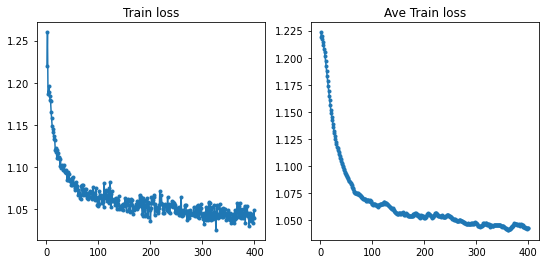

In [27]:
x = range(1, num_epochs+1)
ave_loss = losses.copy()
for k in range(1, len(ave_loss)):
    ave_loss[k] = 0.9 * ave_loss[k-1] + 0.1 * ave_loss[k]

plt.figure(figsize=(9, 4))
plt.subplot(121)
plt.plot(x , losses, '.-')
plt.title('Train loss')
plt.subplot(122)
plt.plot(x , ave_loss, '.-')
plt.title('Ave Train loss')
plt.show()

1

In [32]:
import random


k_folds = 10
index_matrix = np.mat(np.where(np.triu(A_LD) == 1))
association_nam = index_matrix.shape[1]
random_index = index_matrix.T.tolist()
random.seed(seed)
random.shuffle(random_index)
CV_size = int(association_nam / k_folds)
temp = np.array(random_index[:association_nam - association_nam %
                                 k_folds]).reshape(k_folds, CV_size,  -1).tolist()
temp[k_folds - 1] = temp[k_folds - 1] + \
        random_index[association_nam - association_nam % k_folds:]

random_index = temp

edge_index = torch.from_numpy(index_matrix)
val_edge_index = torch.tensor(np.array(random_index[5])).transpose(0, 1)
train_edge_index = torch.cat((torch.tensor(np.concatenate(random_index[:5])), torch.tensor(np.concatenate(random_index[6:])))).transpose(0, 1)

edge_index.shape, val_edge_index.shape, train_edge_index.shape

(torch.Size([2, 9886]), torch.Size([2, 988]), torch.Size([2, 8898]))

In [38]:
rev_train_edge_index = torch.cat((train_edge_index[0].unsqueeze(0), train_edge_index[1].unsqueeze(0)), dim=0)
rev_val_edge_index = torch.cat((val_edge_index[0].unsqueeze(0), val_edge_index[1].unsqueeze(0)), dim=0)
train_edge_index = torch.cat((train_edge_index ,rev_train_edge_index), dim=1)
val_edge_index = torch.cat((val_edge_index ,rev_val_edge_index), dim=1)
val_edge_index.shape, train_edge_index.shape

(torch.Size([2, 1976]), torch.Size([2, 17796]))

In [70]:
train_edge_index.shape[1] / (594*594), train_dataset.edge_index.shape[1] / (7813*7813)

(0.05043703023501003, 0.0005598351548070999)

In [60]:
from torch_geometric.nn import GCNConv
from torch_geometric.nn import InnerProductDecoder
from torch_geometric.nn import GAE
EPS = 1e-15

class GCNEncoder(nn.Module):
    def  __init__(self, in_channels, hidden_size, out_channels, dropout):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_size, cached=True)
        self.conv2 = GCNConv(hidden_size, out_channels, cached=True)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.dropout(x)
        return self.conv2(x, edge_index)

'''    
class GraphAutoEncoder(nn.Module):
    def __init__(self, encoder, decoder=InnerProductDecoder(), graph_type='sparse'):
        super(GraphAutoEncoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.graph_type = graph_type
    
    def encode(self, x, edge_index):
        return self.encoder(x, edge_index)
    
    def recon_loss(self, z, pos_edge_index, neg_edge_index=None):
        pos_loss = -torch.log(
            self.decoder(z, pos_edge_index, sigmoid=True) + EPS).mean()
        if neg_edge_index is None:
            neg_edge_index = negative_sampling(pos_edge_index, z.size(0),method=self.graph_type)
        neg_loss = -torch.log(1 -
                              self.decoder(z, neg_edge_index, sigmoid=True) +
                              EPS).mean()

        return pos_loss + neg_loss
    
    def test(self, z, pos_edge_index, neg_edge_index):
        from sklearn.metrics import average_precision_score, roc_auc_score

        pos_y = z.new_ones(pos_edge_index.size(1))
        neg_y = z.new_zeros(neg_edge_index.size(1))
        y = torch.cat([pos_y, neg_y], dim=0)

        pos_pred = self.decoder(z, pos_edge_index, sigmoid=True)
        neg_pred = self.decoder(z, neg_edge_index, sigmoid=True)
        pred = torch.cat([pos_pred, neg_pred], dim=0)

        y, pred = y.detach().cpu().numpy(), pred.detach().cpu().numpy()

        return roc_auc_score(y, pred), average_precision_score(y, pred)
    '''
class GraphAutoEncoder(nn.Module):
    def __init__(self, gae, graph_type='sparse'):
        super(GraphAutoEncoder, self).__init__()
        self.gae = gae
        self.graph_type = graph_type
    
    def encode(self, x, edge_index):
        return self.gae.encode(x, edge_index)
    
    def test(self, z, pos_edge_index, neg_edge_index):
        return self.gae.test(z, pos_edge_index, neg_edge_index)
    
    def recon_loss(self, z, pos_edge_index, neg_edge_index=None):
        pos_loss = -torch.log(
            self.gae.decoder(z, pos_edge_index, sigmoid=True) + EPS).mean()
        if neg_edge_index is None:
            neg_edge_index = negative_sampling(pos_edge_index, z.size(0),method=self.graph_type)
        neg_loss = -torch.log(1 -
                              self.gae.decoder(z, neg_edge_index, sigmoid=True) +
                              EPS).mean()

        return pos_loss + neg_loss

In [68]:
from torch_geometric.utils import negative_sampling


EPOCHS = 1000
learning_rate = 0.01

#NUM_FEATURES = X_LD.shape[1]
NUM_FEATURES = 1
HIDDEN_SIZE = 128
OUT_CHANNELS = 16

X = torch.ones(X_LD.shape[0],1)
gae_model = GAE(GCNEncoder(NUM_FEATURES, HIDDEN_SIZE, OUT_CHANNELS, 0.5))
#gae_model = GraphAutoEncoder(GCNEncoder(NUM_FEATURES, HIDDEN_SIZE, OUT_CHANNELS, 0.5), graph_type='dense')
#gae_model = GraphAutoEncoder(gae=GAE(GCNEncoder(NUM_FEATURES, HIDDEN_SIZE, OUT_CHANNELS, 0.5)), graph_type='dense')

def gae_train(x, edge_index, gae_model, optimizer):
    gae_model.train()
    optimizer.zero_grad()
    z = gae_model.encode(x, edge_index)
    loss = gae_model.recon_loss(z, edge_index)
    loss.backward(retain_graph=True)
    optimizer.step()
    return z, float(loss)


@torch.no_grad()
def gae_test(z, pos_edge_index, gae_model):
    gae_model.eval()
    neg_edge_index = negative_sampling(pos_edge_index, z.size(0), method='dense')
    # neg_edge_index = negative_sampling(pos_edge_index, z.size(0))
    return gae_model.test(z, pos_edge_index, neg_edge_index)

losses = []
test_auc = []
test_ap = []
train_aucs = []
train_aps = []

optimizer = torch.optim.Adam(gae_model.parameters(), lr=learning_rate)

for epoch in range(1, EPOCHS + 1):
    
    
    z, loss = gae_train(X, train_edge_index, gae_model, optimizer)
    losses.append(loss)
    
    
    auc, ap = gae_test(z, val_edge_index, gae_model)
    test_auc.append(auc)
    test_ap.append(ap)

    train_auc, train_ap = gae_test(z, train_edge_index, gae_model)

    train_aucs.append(train_auc)
    train_aps.append(train_ap)
    
    if(epoch % 200 == 0):
        print('Epoch: {:03d}, test AUC: {:.4f}, test AP: {:.4f}, train AUC: {:.4f}, train AP: {:.4f}, loss:{:.4f}'.format(epoch, auc, ap, train_auc, train_ap, loss))

Epoch: 200, test AUC: 0.6595, test AP: 0.6609, train AUC: 0.6777, train AP: 0.6777, loss:1.3163
Epoch: 400, test AUC: 0.6514, test AP: 0.6529, train AUC: 0.7072, train AP: 0.7119, loss:1.2866
Epoch: 600, test AUC: 0.6780, test AP: 0.6808, train AUC: 0.7134, train AP: 0.7212, loss:1.2780
Epoch: 800, test AUC: 0.6520, test AP: 0.6550, train AUC: 0.7097, train AP: 0.7101, loss:1.2859
Epoch: 1000, test AUC: 0.6812, test AP: 0.6830, train AUC: 0.7278, train AP: 0.7301, loss:1.2647


第一次训练结果：
Epoch: 200, test AUC: 0.6420, test AP: 0.6422, train AUC: 0.6819, train AP: 0.6833, loss:1.3118
Epoch: 400, test AUC: 0.6307, test AP: 0.6268, train AUC: 0.6712, train AP: 0.6722, loss:1.3283
Epoch: 600, test AUC: 0.6398, test AP: 0.6426, train AUC: 0.6910, train AP: 0.6915, loss:1.3261
Epoch: 800, test AUC: 0.6829, test AP: 0.6774, train AUC: 0.7279, train AP: 0.7293, loss:1.2676
Epoch: 1000, test AUC: 0.6943, test AP: 0.6972, train AUC: 0.7430, train AP: 0.7420, loss:1.2542
loss较高、test AUC和train AUC都不高的原因：边稠密，导致稀疏负采样不合理？

第二次训练结果，稠密图采样，不是该原因：
Epoch: 200, test AUC: 0.6595, test AP: 0.6609, train AUC: 0.6777, train AP: 0.6777, loss:1.3163
Epoch: 400, test AUC: 0.6514, test AP: 0.6529, train AUC: 0.7072, train AP: 0.7119, loss:1.2866
Epoch: 600, test AUC: 0.6780, test AP: 0.6808, train AUC: 0.7134, train AP: 0.7212, loss:1.2780
Epoch: 800, test AUC: 0.6520, test AP: 0.6550, train AUC: 0.7097, train AP: 0.7101, loss:1.2859
Epoch: 1000, test AUC: 0.6812, test AP: 0.6830, train AUC: 0.7278, train AP: 0.7301, loss:1.2647

换超参：****补实验，找一下论文可以怎么调惨

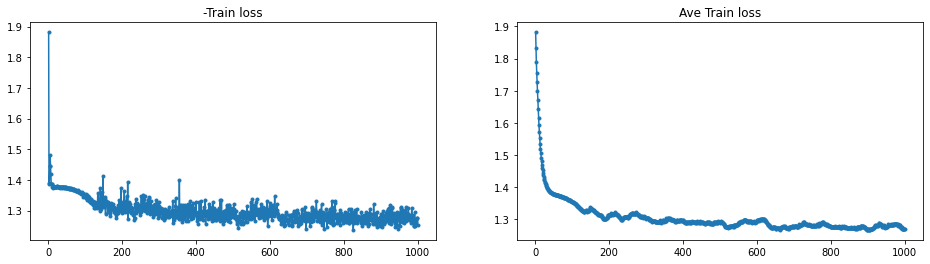

In [67]:
#第一次训练，
x = range(1, EPOCHS+1)
ave_loss = losses.copy()
for k in range(1, len(ave_loss)):
    ave_loss[k] = 0.9 * ave_loss[k-1] + 0.1 * ave_loss[k]

plt.figure(figsize=(16, 4))
plt.subplot(121)
plt.plot(x , losses, '.-')
plt.title('-Train loss')
plt.subplot(122)
plt.plot(x , ave_loss, '.-')
plt.title('Ave Train loss')
plt.show()

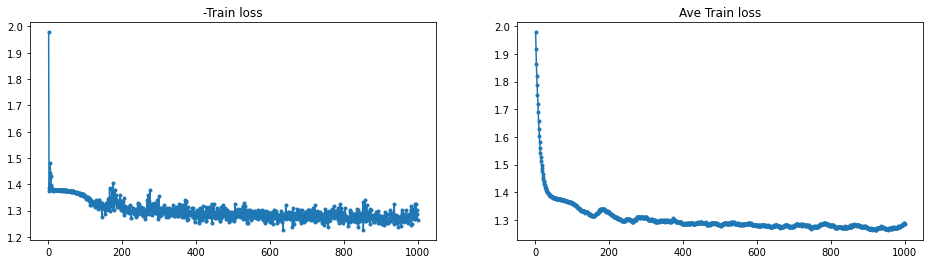

In [69]:
#第二次训练，
x = range(1, EPOCHS+1)
ave_loss = losses.copy()
for k in range(1, len(ave_loss)):
    ave_loss[k] = 0.9 * ave_loss[k-1] + 0.1 * ave_loss[k]

plt.figure(figsize=(16, 4))
plt.subplot(121)
plt.plot(x , losses, '.-')
plt.title('-Train loss')
plt.subplot(122)
plt.plot(x , ave_loss, '.-')
plt.title('Ave Train loss')
plt.show()